# Import librairies

In [1]:
import pandas as pd, numpy as np, seaborn as sns, warnings, os
from datetime import datetime as dt
from matplotlib import pyplot as plt

import matplotlib.font_manager as fm
import plotly.express as px
import plotly.graph_objs as go

font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

warnings.filterwarnings(action="ignore")

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
sns.set(font_scale=3)

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Outils

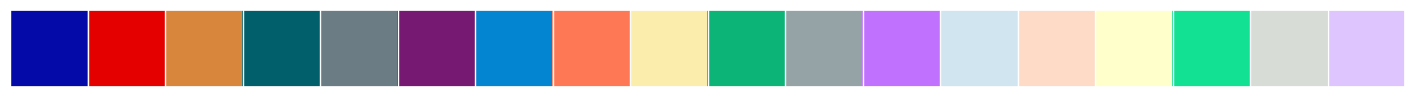

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", 
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#c071fe", 
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#dfc5fe", 
          ]
sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = 'ConsolidationDonneesMeteoJour'

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

In [5]:
donnees = pd.read_parquet("donnees/donnees_meteo.gzip")
donnees.set_index(['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],inplace=True)

In [6]:
donnees[['VitesseVent','Temperature','Humidite','Pression','Visibilite','Precipitation']].head()

VitesseVent  Temperature  \
Nom       Latitude Longitude Altitude Zone                             
Abbeville 50.136   1.834     69       NO            2.0         2.89   
                                      NO            3.0         2.70   
                                      NO            3.0         2.89   
                                      NO            4.1         3.60   
                                      NO            5.1         4.39   

                                            Humidite  Pression  Visibilite  \
Nom       Latitude Longitude Altitude Zone                                   
Abbeville 50.136   1.834     69       NO        99.0     990.9         NaN   
                                      NO        99.0     990.7         NaN   
                                      NO        99.0     990.9         0.1   
                                      NO        99.0     991.1         0.8   
                                      NO        99.0     990.4         1.6   

                                            Precipitation  
Nom       Latitude Longitude Altitude Zone                 
Abbeville 50.136   1.834     69       NO              0.0  
                                      NO              0.2  
                                      NO              0.0  
                                      NO              0.0  
                                      NO              0.0

# Moyenne journalière  par ville 

In [7]:
donneesJ = donnees.reset_index().pivot_table(index=['Nom', 'Latitude', 'Longitude', 'Altitude', 'Zone'],
                                 columns='JourA',
                                 values=['Temperature','Humidite','Pression'],  
                                 aggfunc = 'mean',
                                 sort = False)

donneesJ.columns=[f'{column[0]}{column[1]:03d}' for column in donneesJ.columns]
donneesJ.to_parquet(os.path.join(repertoireDonnees,'donneesJ.gzip'),compression='gzip', engine='pyarrow') 
donneesJ.head()

Temperature001  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.683491   
Lille           50.570000  3.097500 47       NE          4.343621   
Pte De La Hague 49.725167 -1.939833 6        NO          8.577956   
Caen            49.180000 -0.456167 67       NO          5.914537   
Rouen           49.383000  1.181667 151      NO          4.510133   

                                                   Temperature002  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.295043   
Lille           50.570000  3.097500 47       NE          4.771558   
Pte De La Hague 49.725167 -1.939833 6        NO          8.780938   
Caen            49.180000 -0.456167 67       NO          6.288276   
Rouen           49.383000  1.181667 151      NO          5.053870   

                                                   Temperature003  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.985109   
Lille           50.570000  3.097500 47       NE          4.365603   
Pte De La Hague 49.725167 -1.939833 6        NO          8.637991   
Caen            49.180000 -0.456167 67       NO          6.016422   
Rouen           49.383000  1.181667 151      NO          4.656578   

                                                   Temperature004  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.023664   
Lille           50.570000  3.097500 47       NE          4.604483   
Pte De La Hague 49.725167 -1.939833 6        NO          8.382232   
Caen            49.180000 -0.456167 67       NO          5.981039   
Rouen           49.383000  1.181667 151      NO          4.623722   

                                                   Temperature005  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.936724   
Lille           50.570000  3.097500 47       NE          4.408276   
Pte De La Hague 49.725167 -1.939833 6        NO          8.400089   
Caen            49.180000 -0.456167 67       NO          5.883247   
Rouen           49.383000  1.181667 151      NO          4.757991   

                                                   Temperature006  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          4.831638   
Lille           50.570000  3.097500 47       NE          4.276537   
Pte De La Hague 49.725167 -1.939833 6        NO          8.101937   
Caen            49.180000 -0.456167 67       NO          5.602251   
Rouen           49.383000  1.181667 151      NO          4.443604   

                                                   Temperature007  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.358621   
Lille           50.570000  3.097500 47       NE          4.751169   
Pte De La Hague 49.725167 -1.939833 6        NO          8.313443   
Caen            49.180000 -0.456167 67       NO          6.013550   
Rouen           49.383000  1.181667 151      NO          4.753158   

                                                   Temperature008  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO          5.318319   
Lille           50.570000  3.097500 47       NE          4.914762   
Pte De La Hague 49.725167 -1.939833 6        NO          8.372273   
Caen            49.180000 -0.456167 67       NO          6.362251   
Rouen           49.383000  1.181667 151      NO          4.945455   

                                                   Temperature009  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69   

# Centrage et réduction des données


<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/moyenne.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/ecart_type.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/centrage_reduction.png"></th>
</tr>
</table>

In [8]:
modelStd = StandardScaler()
modelStd.fit(donneesJ)
donneesJ[donneesJ.columns] = modelStd.transform(donneesJ)
donneesJ.head()

Temperature001  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.642492   
Lille           50.570000  3.097500 47       NE         -0.801995   
Pte De La Hague 49.725167 -1.939833 6        NO          1.185207   
Caen            49.180000 -0.456167 67       NO         -0.064753   
Rouen           49.383000  1.181667 151      NO         -0.723850   

                                                   Temperature002  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.486483   
Lille           50.570000  3.097500 47       NE         -0.729321   
Pte De La Hague 49.725167 -1.939833 6        NO          1.130579   
Caen            49.180000 -0.456167 67       NO         -0.025735   
Rouen           49.383000  1.181667 151      NO         -0.598361   

                                                   Temperature003  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.541850   
Lille           50.570000  3.097500 47       NE         -0.817998   
Pte De La Hague 49.725167 -1.939833 6        NO          1.086437   
Caen            49.180000 -0.456167 67       NO         -0.082138   
Rouen           49.383000  1.181667 151      NO         -0.688295   

                                                   Temperature004  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.501033   
Lille           50.570000  3.097500 47       NE         -0.693759   
Pte De La Hague 49.725167 -1.939833 6        NO          1.043129   
Caen            49.180000 -0.456167 67       NO         -0.060862   
Rouen           49.383000  1.181667 151      NO         -0.684913   

                                                   Temperature005  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.352364   
Lille           50.570000  3.097500 47       NE         -0.604219   
Pte De La Hague 49.725167 -1.939833 6        NO          1.298253   
Caen            49.180000 -0.456167 67       NO          0.098742   
Rouen           49.383000  1.181667 151      NO         -0.437547   

                                                   Temperature006  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.278393   
Lille           50.570000  3.097500 47       NE         -0.534397   
Pte De La Hague 49.725167 -1.939833 6        NO          1.229820   
Caen            49.180000 -0.456167 67       NO          0.077003   
Rouen           49.383000  1.181667 151      NO         -0.457348   

                                                   Temperature007  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.182319   
Lille           50.570000  3.097500 47       NE         -0.472382   
Pte De La Hague 49.725167 -1.939833 6        NO          1.228631   
Caen            49.180000 -0.456167 67       NO          0.130415   
Rouen           49.383000  1.181667 151      NO         -0.471432   

                                                   Temperature008  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69       NO         -0.407915   
Lille           50.570000  3.097500 47       NE         -0.608739   
Pte De La Hague 49.725167 -1.939833 6        NO          1.111845   
Caen            49.180000 -0.456167 67       NO          0.111584   
Rouen           49.383000  1.181667 151      NO         -0.593466   

                                                   Temperature009  \
Nom             Latitude  Longitude Altitude Zone                   
Abbeville       50.136000  1.834000 69   

# Analyse en composantes principales

<table>
<tr>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/axe_variance_max.png"></th>
<th><img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/refs/heads/main/images/max_dist.png"></th>
</tr>
</table>



In [9]:
modelPCA = PCA()
modelPCA.fit(donneesJ)
modelPCA.explained_variance_ratio_.cumsum()*100

array([ 47.37382353,  84.37201216,  93.83755382,  96.14366055,
        97.1645577 ,  97.71267885,  98.0889297 ,  98.35768523,
        98.61440302,  98.83975735,  98.99795127,  99.12578893,
        99.22650967,  99.31355691,  99.3916225 ,  99.45912796,
        99.51643748,  99.56483792,  99.60858855,  99.64948907,
        99.68475357,  99.71744386,  99.74848309,  99.77460222,
        99.79802966,  99.8206319 ,  99.84220422,  99.86093696,
        99.87768506,  99.8940842 ,  99.90817109,  99.92208786,
        99.9348881 ,  99.94571114,  99.95613403,  99.96574694,
        99.97474285,  99.98190681,  99.98869076,  99.9946678 ,
       100.        , 100.        ])

## Choix du nombre des dimensions

In [10]:
sum(modelPCA.explained_variance_ratio_.cumsum()*100 <= 95) + 1

4

## Pourcentage d'inertie associée à chaque dimension

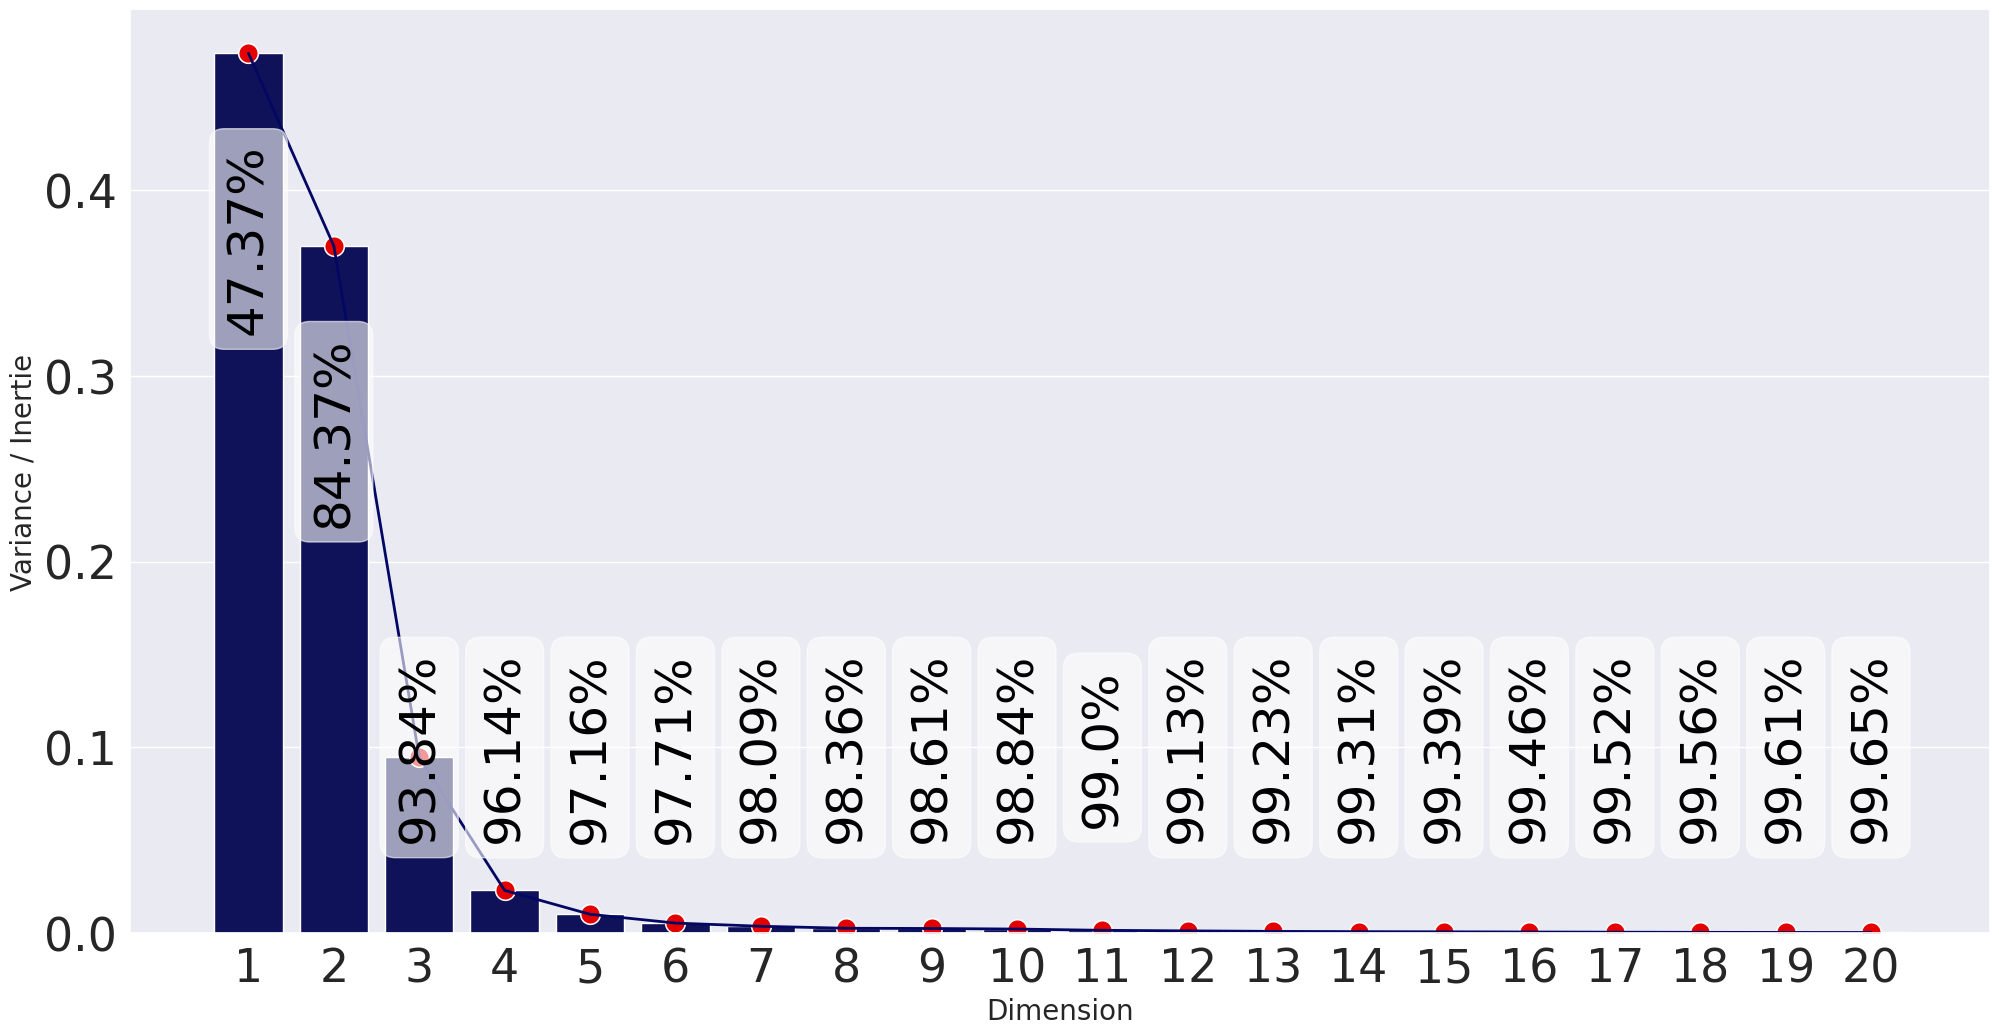

In [11]:
inertie = pd.DataFrame(modelPCA.explained_variance_ratio_,columns=['Inertie']) 
inertie['Label'] = np.round(modelPCA.explained_variance_ratio_.cumsum()*100,2)
inertie['Dimension'] = range(1,len(modelPCA.explained_variance_)+1)
# Affichage des 5 dimensions
dim = 20
inertie = inertie[inertie['Dimension']<= dim]

fig, ax = plt.subplots(figsize=(24,12));
graph = sns.barplot(x="Dimension",y='Inertie', data=inertie, color="#030764", ax=ax)

for i,(nom,valeur) in enumerate(zip(inertie.sort_values('Dimension').Label,inertie.sort_values('Dimension').Inertie)):
    valeur = 0.1 if valeur - 0.1 < 0.1 else valeur - 0.1
    delta =  i 
    graph.text(
                delta ,
                valeur,
                f'{nom}%',
                color='black',
                rotation='vertical',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.6),
                verticalalignment='center',
                horizontalalignment='center',
               )
    
graph = sns.lineplot( x=inertie.Dimension - 1,
                      y='Inertie',
                      data=inertie,
                      estimator = None, 
                      lw        = 2, 
                      ci        = None,
                      color     = "#030764",
                      ax    = ax);

sns.scatterplot(x=inertie.Dimension - 1,
                y     = 'Inertie',
                data  = inertie,
                s     = 200,
                # ci    = None, 
                color = "#e50000",
                ax    = ax);    
    
plt.xlabel('Dimension', fontproperties=font1)
plt.ylabel('Variance / Inertie', fontproperties=font1)

sauvegarderImage('Choix du nombre des dimensions--Temperatures')
plt.show()
sns.set(font_scale=2)

## Transformation des données 

In [12]:
n_components = sum(modelPCA.explained_variance_ratio_.cumsum() < .95 ) + 1 
modelPCA = PCA(n_components=n_components)
x_proj = modelPCA.fit_transform(donneesJ)
donnees = pd.DataFrame(x_proj, index=donneesJ.index, columns=[f'Dimension{i:02d}' for i in range(1,n_components+1)])

In [13]:
donnees.head()

Dimension01  Dimension02  \
Nom             Latitude  Longitude Altitude Zone                             
Abbeville       50.136000  1.834000 69       NO      -4.811359    26.130807   
Lille           50.570000  3.097500 47       NE      -1.491004    17.572957   
Pte De La Hague 49.725167 -1.939833 6        NO      10.543648    29.577911   
Caen            49.180000 -0.456167 67       NO      -0.871848    26.037489   
Rouen           49.383000  1.181667 151      NO     -11.439717    21.819682   

                                                   Dimension03  Dimension04  
Nom             Latitude  Longitude Altitude Zone                            
Abbeville       50.136000  1.834000 69       NO      -0.523055    -5.601760  
Lille           50.570000  3.097500 47       NE     -10.179028    -6.424470  
Pte De La Hague 49.725167 -1.939833 6        NO      21.930086    -7.439763  
Caen            49.180000 -0.456167 67       NO       3.778734    -4.211083  
Rouen           49.383000  1.181667 151      NO      -3.779959    -1.886567

In [14]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Zone',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

# Classification hiérarchique ascendante

In [15]:
Villes = donnees.reset_index().Nom.values
donnees.head()

Dimension01  Dimension02  \
Nom             Latitude  Longitude Altitude Zone                             
Abbeville       50.136000  1.834000 69       NO      -4.811359    26.130807   
Lille           50.570000  3.097500 47       NE      -1.491004    17.572957   
Pte De La Hague 49.725167 -1.939833 6        NO      10.543648    29.577911   
Caen            49.180000 -0.456167 67       NO      -0.871848    26.037489   
Rouen           49.383000  1.181667 151      NO     -11.439717    21.819682   

                                                   Dimension03  Dimension04  
Nom             Latitude  Longitude Altitude Zone                            
Abbeville       50.136000  1.834000 69       NO      -0.523055    -5.601760  
Lille           50.570000  3.097500 47       NE     -10.179028    -6.424470  
Pte De La Hague 49.725167 -1.939833 6        NO      21.930086    -7.439763  
Caen            49.180000 -0.456167 67       NO       3.778734    -4.211083  
Rouen           49.383000  1.181667 151      NO      -3.779959    -1.886567

## Calcul des arbres 

In [16]:
def afficheDendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Classification Hiérarchique Ascendante')
        plt.xlabel('Villes ou (taille du cluster)')
        plt.ylabel('Distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [17]:
Z = linkage(donnees, 'ward')

## Affichage des arbres *3 clases* par défaut 

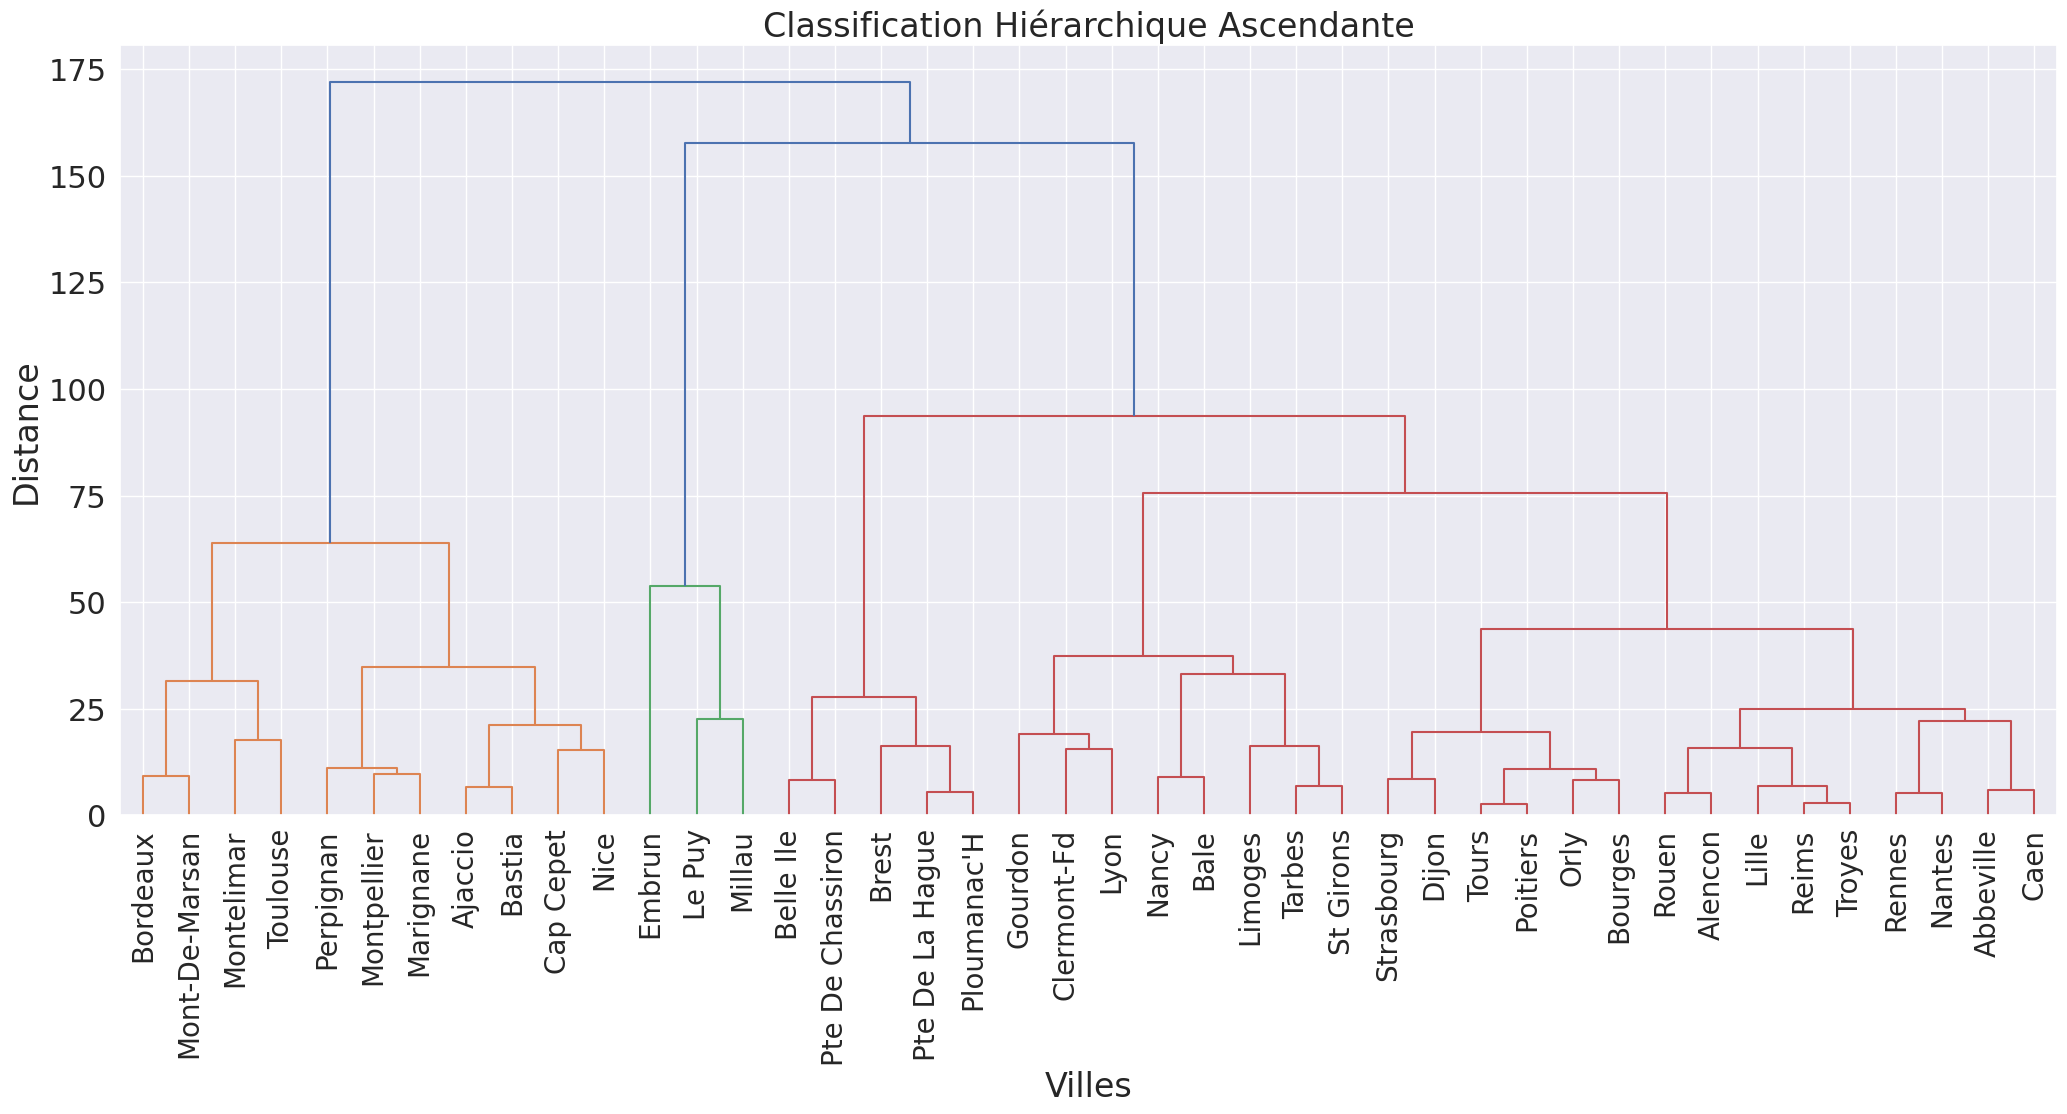

In [18]:
plt.figure(figsize=(25, 10))
plt.title('Classification Hiérarchique Ascendante')
plt.xlabel('Villes')
plt.ylabel('Distance')
dendrogram( Z,leaf_rotation=90.,leaf_font_size=20.,
           labels = Villes)
plt.show()

## Affichage des arbres *6 clases*

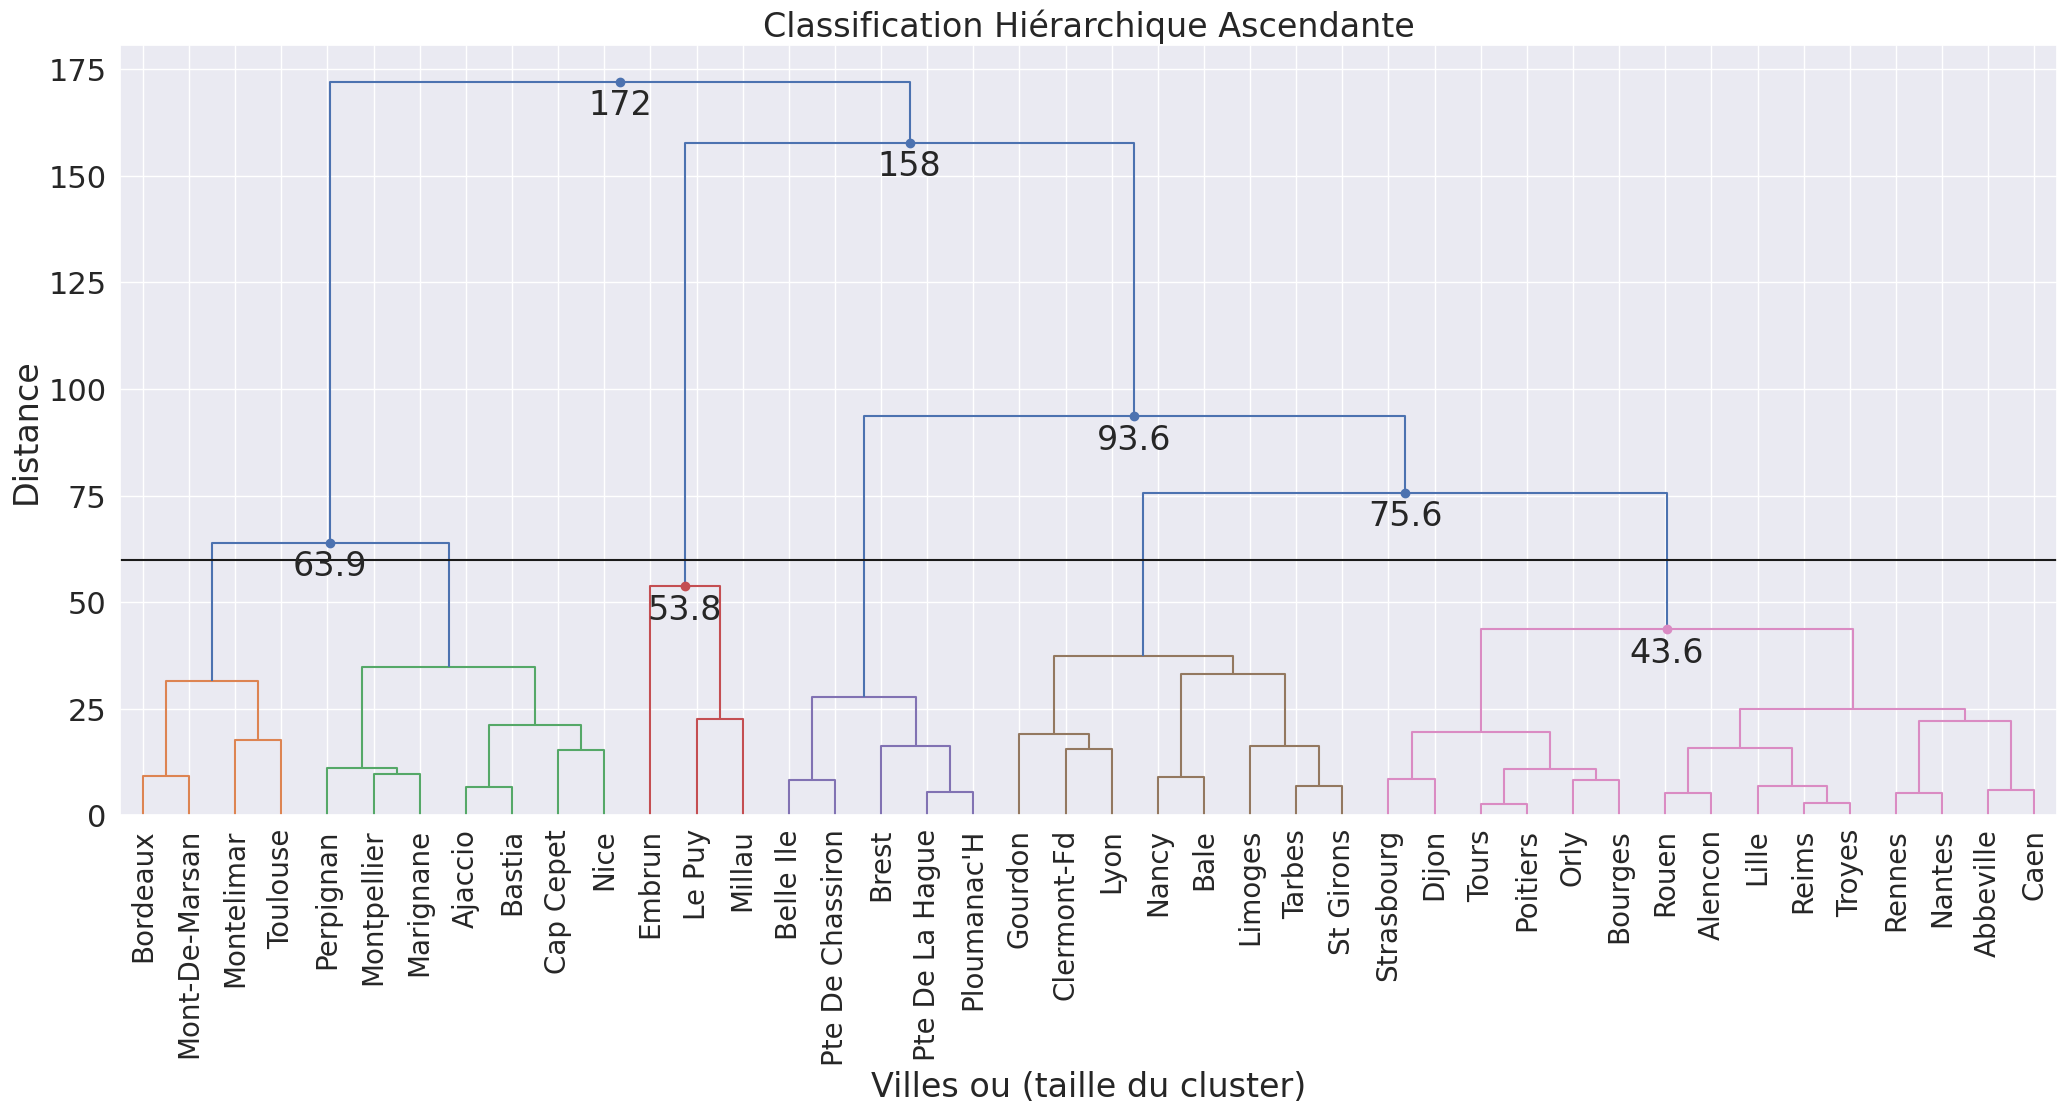

In [19]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=40,             # les annotations à partir de cette distance
    max_d=60,                      # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

## Affichage des arbres *5 clases*

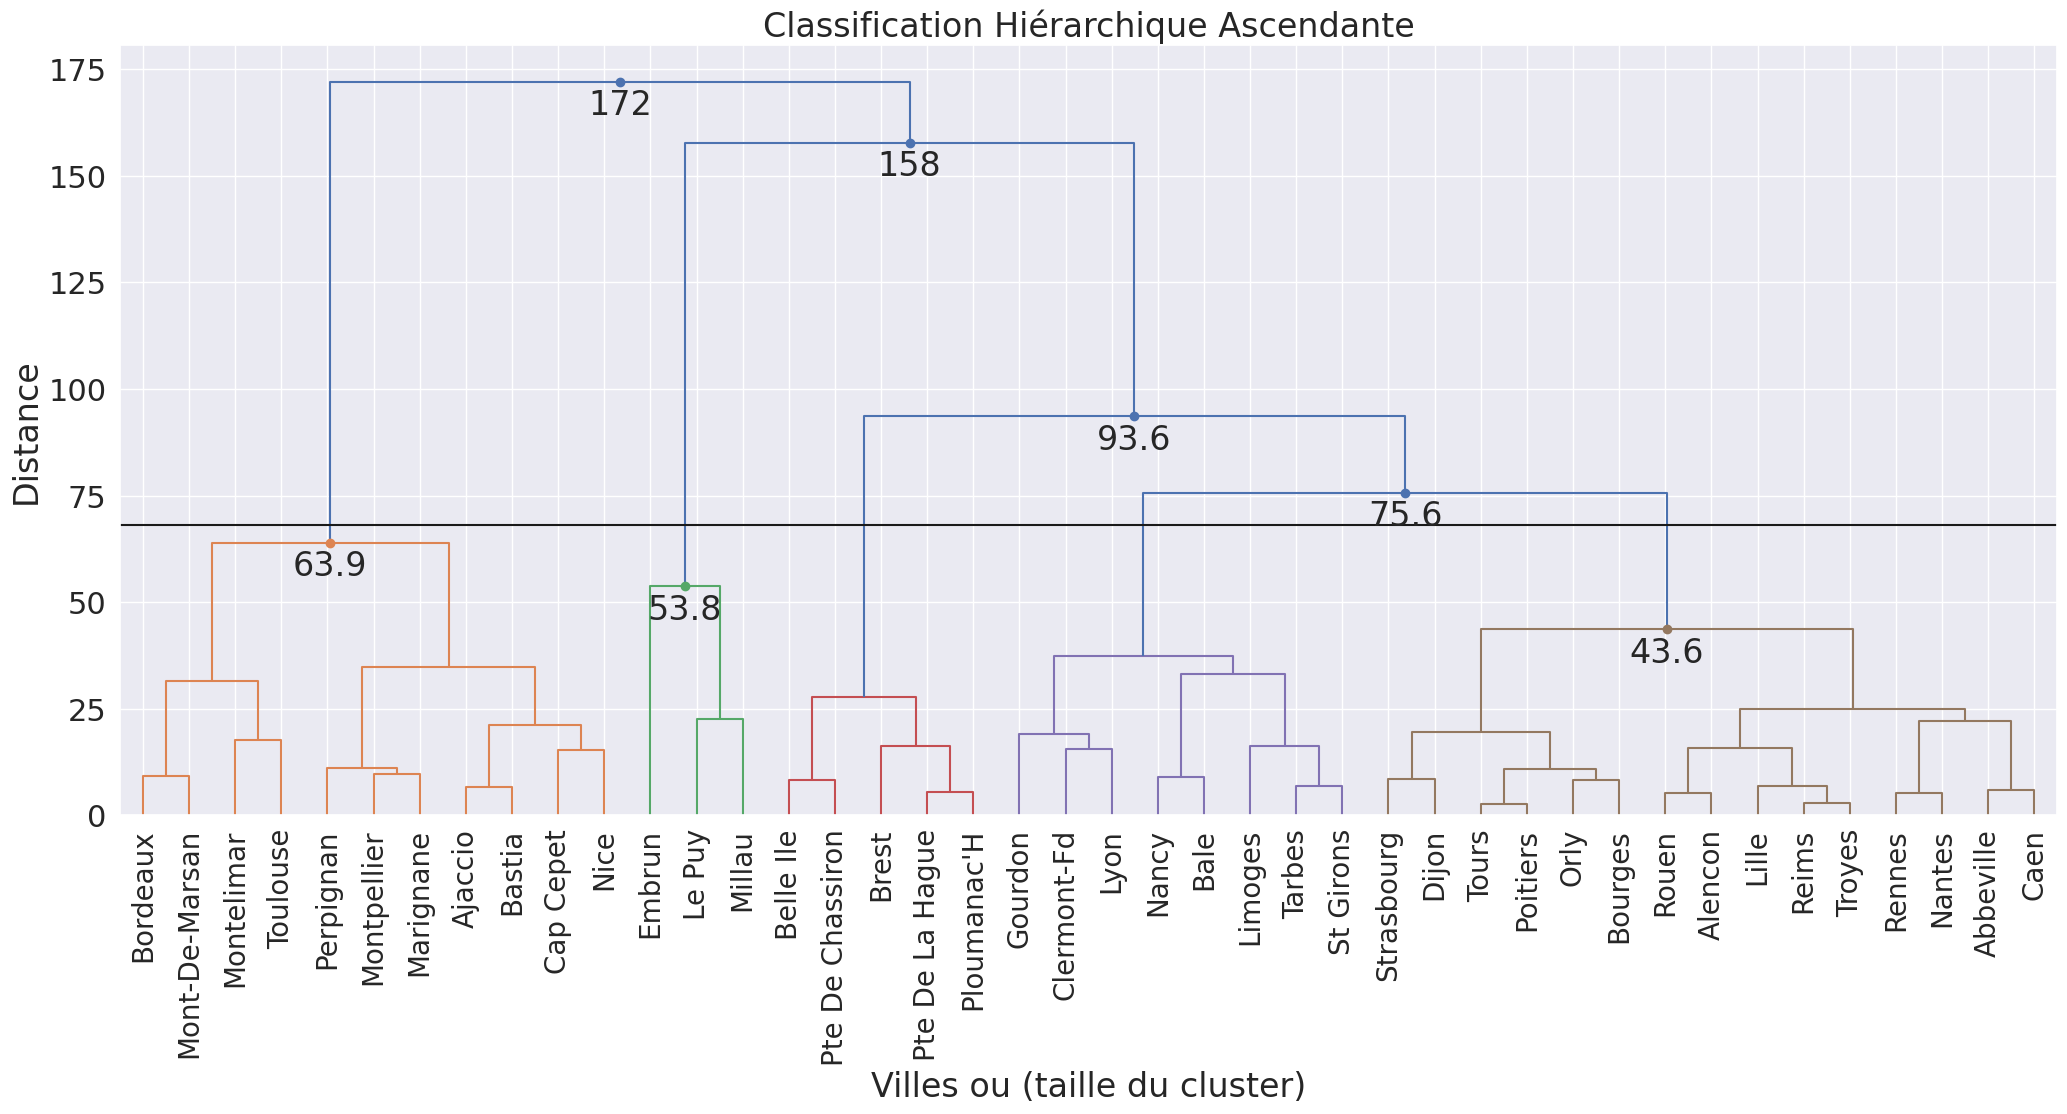

In [20]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=40,             # les annotations à partir de cette distance
    max_d=68,                      # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

## Affichage des arbres *4 clases*

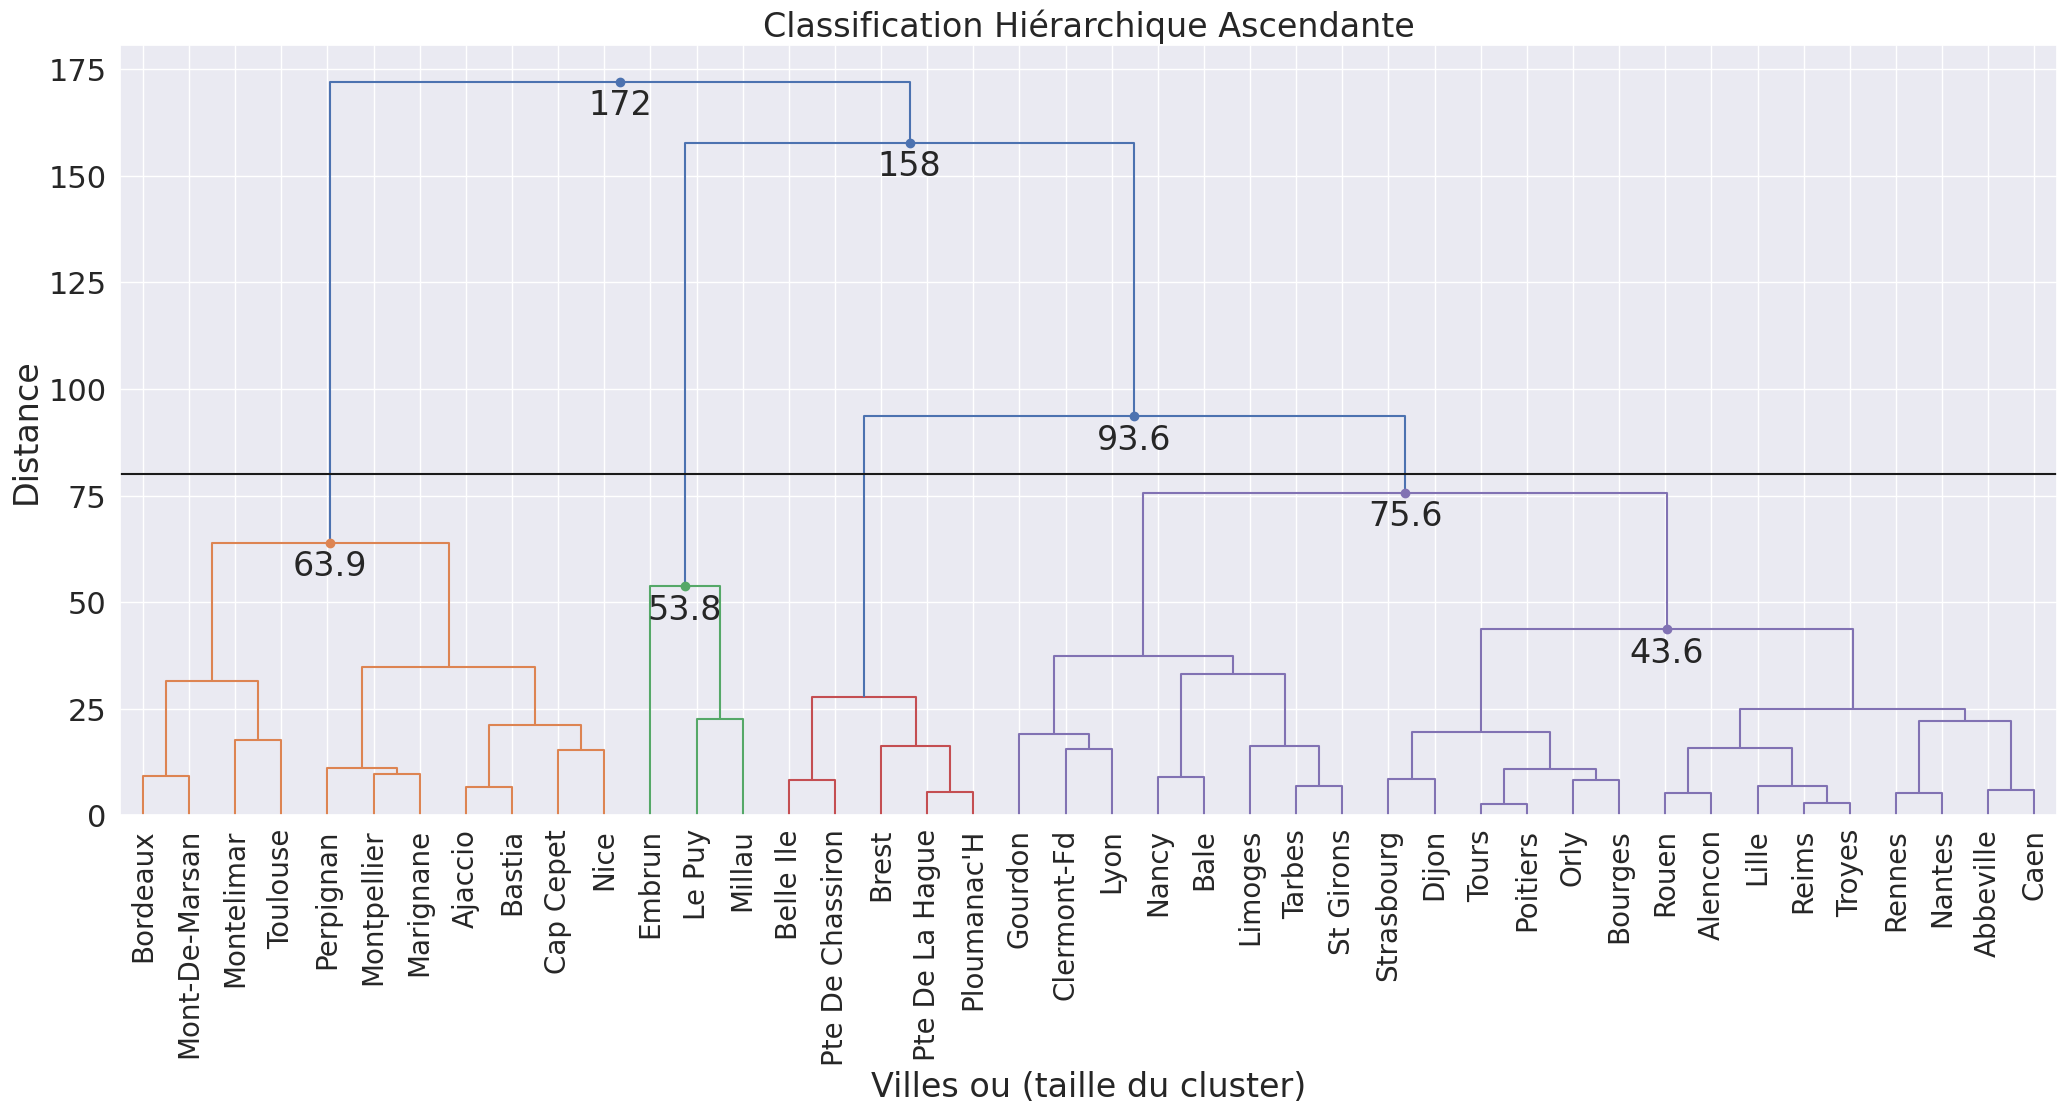

In [21]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=40,              # les annotations à partir de cette distance
    max_d=80,                      # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

## Affichage des arbres *3 clases*

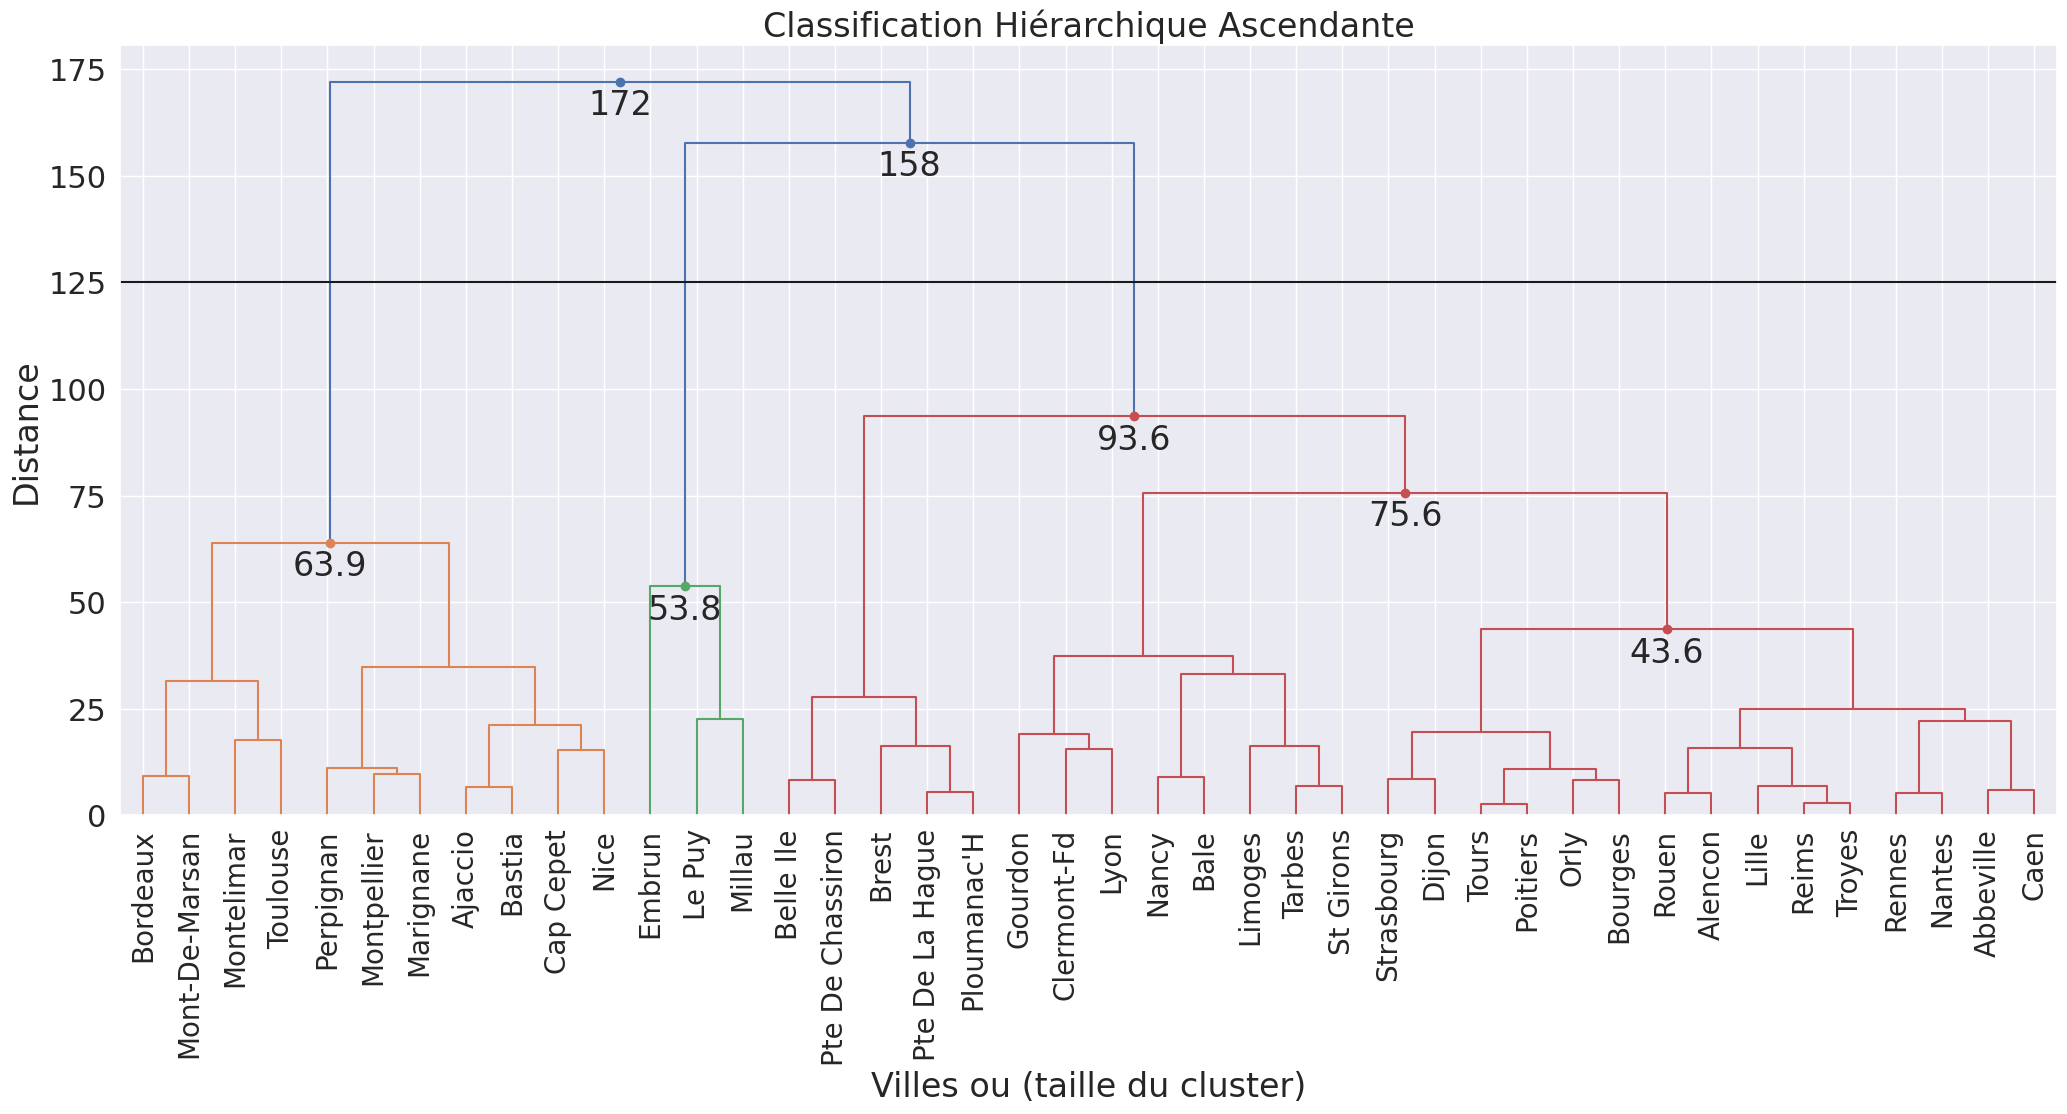

In [22]:
plt.figure(figsize=(25, 10))
afficheDendrogram(
    Z,
    truncate_mode='lastp',
    p=42,                          # nombres des classes
    leaf_rotation=90.,
    leaf_font_size=20.,
    show_contracted=True,
    annotate_above=40,              # les annotations à partir de cette distance
    max_d=125,                      # la distance de découpage de l’arbre
    labels = Villes
)
plt.show()

## Prédiction des classes

In [23]:
donnees['Classes6']=fcluster(Z, t=60, criterion='distance')
donnees['Classes5']=fcluster(Z, t=68, criterion='distance')
donnees['Classes4']=fcluster(Z, t=80, criterion='distance')
donnees['Classes3']=fcluster(Z, t=125, criterion='distance')

In [24]:
donnees.reset_index()

Nom   Latitude  Longitude  Altitude Zone  Dimension01  \
0          Abbeville  50.136000   1.834000        69   NO    -4.811359   
1              Lille  50.570000   3.097500        47   NE    -1.491004   
2    Pte De La Hague  49.725167  -1.939833         6   NO    10.543648   
3               Caen  49.180000  -0.456167        67   NO    -0.871848   
4              Rouen  49.383000   1.181667       151   NO   -11.439717   
5              Reims  49.209667   4.155333        95   NE    -3.620480   
6              Brest  48.444167  -4.412000        94   NO    -1.090187   
7        Ploumanac'H  48.825833  -3.473167        55   NO     6.415409   
8             Rennes  48.068833  -1.734000        36   NO     6.139510   
9            Alencon  48.445500   0.110167       143   NO    -8.080753   
10              Orly  48.716833   2.384333        89   NO     1.694970   
11            Troyes  48.324667   4.020000       112   NE    -4.986280   
12             Nancy  48.581000   5.959833       336   NE   -27.250304   
13        Strasbourg  48.549500   7.640333       150   NE    -7.677247   
14         Belle Ile  47.294333  -3.218333        34   NO    13.618779   
15            Nantes  47.150000  -1.608833        26   NO     9.897482   
16             Tours  47.444500   0.727333       108   NO     0.702779   
17           Bourges  47.059167   2.359833       161   NO    -3.419844   
18             Dijon  47.267833   5.088333       219   NE   -12.967630   
19              Bale  47.614333   7.510000       263   NE   -18.705318   
20  Pte De Chassiron  46.046833  -1.411500        11   SO    18.892442   
21          Poitiers  46.593833   0.314333       123   NO     0.363451   
22           Limoges  45.861167   1.175000       402   SO   -22.588326   
23       Clermont-Fd  45.786833   3.149333       331   SE   -12.433846   
24            Le Puy  45.074500   3.764000       833   SE   -67.644222   
25              Lyon  45.726500   5.077833       235   SE    -3.850065   
26          Bordeaux  44.830667  -0.691333        47   SO    17.309509   
27           Gourdon  44.745000   1.396667       260   SO    -5.520550   
28            Millau  44.118500   3.019500       712   SE   -47.732037   
29        Montelimar  44.581167   4.733000        73   SE    17.276841   
30            Embrun  44.565667   6.502333       871   SE   -56.362837   
31    Mont-De-Marsan  43.909833  -0.500167        59   SO    13.259617   
32            Tarbes  43.188000   0.000000       360   SO   -12.460868   
33         St Girons  43.005333   1.106833       414   SO   -17.342899   
34          Toulouse  43.621000   1.378833       151   SO    11.354114   
35       Montpellier  43.577000   3.963167         2   SE    31.934708   
36         Marignane  43.437667   5.216000         9   SE    31.209534   
37         Cap Cepet  43.079333   5.940833       115   SE    23.863921   
38              Nice  43.648833   7.209000         2   SE    35.903431   
39         Perpignan  42.737167   2.872833        42   SE    34.252219   
40           Ajaccio  41.918000   8.792667         5   SE    32.823055   
41            Bastia  42.540667   9.485167        10   SE    34.892204   

    Dimension02  Dimension03  Dimension04  Classes6  Classes5  Classes4  \
0     26.130807    -0.523055    -5.601760         6         5         4   
1     17.572957   -10.179028    -6.424470         6         5         4   
2     29.577911    21.930086    -7.439763         4         3         3   
3     26.037489     3.778734    -4.211083         6         5         4   
4     21.819682    -3.779959    -1.886567         6         5         4   
5     14.593219    -9.338238    -3.796088         6         5         4   
6     33.040440    13.518211    -0.653523         4         3         3   
7     27.903010    19.821145    -5.268968         4         3         3   
8     18.161417    -2.559489    -1.514356         6         5         4   
9     18.077515    -5.015639    -0.629984         6         5         4   
10     3.

## Affichage des clusters 

In [25]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Classes6',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [26]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Classes5',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [27]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Classes4',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [28]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='Classes3',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

# Clustering non hiérarchique

In [29]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans3'] = y_kmeans+1
kmeans = KMeans(n_clusters=4)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans4'] = y_kmeans+1
kmeans = KMeans(n_clusters=5)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans5'] = y_kmeans+1
kmeans = KMeans(n_clusters=6)
kmeans.fit(donnees.values)
y_kmeans = kmeans.predict(donnees.values)
donnees['KMeans6'] = y_kmeans+1

In [30]:
donnees.head()

Dimension01  Dimension02  \
Nom             Latitude  Longitude Altitude Zone                             
Abbeville       50.136000  1.834000 69       NO      -4.811359    26.130807   
Lille           50.570000  3.097500 47       NE      -1.491004    17.572957   
Pte De La Hague 49.725167 -1.939833 6        NO      10.543648    29.577911   
Caen            49.180000 -0.456167 67       NO      -0.871848    26.037489   
Rouen           49.383000  1.181667 151      NO     -11.439717    21.819682   

                                                   Dimension03  Dimension04  \
Nom             Latitude  Longitude Altitude Zone                             
Abbeville       50.136000  1.834000 69       NO      -0.523055    -5.601760   
Lille           50.570000  3.097500 47       NE     -10.179028    -6.424470   
Pte De La Hague 49.725167 -1.939833 6        NO      21.930086    -7.439763   
Caen            49.180000 -0.456167 67       NO       3.778734    -4.211083   
Rouen           49.383000  1.181667 151      NO      -3.779959    -1.886567   

                                                   Classes6  Classes5  \
Nom             Latitude  Longitude Altitude Zone                       
Abbeville       50.136000  1.834000 69       NO           6         5   
Lille           50.570000  3.097500 47       NE           6         5   
Pte De La Hague 49.725167 -1.939833 6        NO           4         3   
Caen            49.180000 -0.456167 67       NO           6         5   
Rouen           49.383000  1.181667 151      NO           6         5   

                                                   Classes4  Classes3  \
Nom             Latitude  Longitude Altitude Zone                       
Abbeville       50.136000  1.834000 69       NO           4         3   
Lille           50.570000  3.097500 47       NE           4         3   
Pte De La Hague 49.725167 -1.939833 6        NO           3         3   
Caen            49.180000 -0.456167 67       NO           4         3   
Rouen           49.383000  1.181667 151      NO           4         3   

                                                   KMeans3  KMeans4  KMeans5  \
Nom             Latitude  Longitude Altitude Zone                              
Abbeville       50.136000  1.834000 69       NO          1        2        4   
Lille           50.570000  3.097500 47       NE          2        2        2   
Pte De La Hague 49.725167 -1.939833 6        NO          1        2        4   
Caen            49.180000 -0.456167 67       NO          1        2        4   
Rouen           49.383000  1.181667 151      NO          2        2        2   

                                                   KMeans6  
Nom             Latitude  Longitude Altitude Zone           
Abbeville       50.136000  1.834000 69       NO          3  
Lille           50.570000  3.097500 47       NE          3  
Pte De La Hague 49.725167 -1.939833 6        NO          5  
Caen            49.180000 -0.456167 67       NO          3  
Rouen           49.383000  1.181667 151      NO          3

In [31]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='KMeans6',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [32]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='KMeans5',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [33]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='KMeans4',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()

In [34]:
layout = go.Layout({"showlegend": False})
affichage = donnees.reset_index()
fig = px.scatter_3d(affichage, 
                    x='Dimension01', 
                    y='Dimension02', 
                    z='Dimension03',
                    color='KMeans3',
                    # size= 'Dimension04',
                    # symbol=donnees.CD23.cat.codes,
                    text='Nom',
                    width=1024,
                    height=1024,
                   )

fig.show()